In [9]:
import numpy as np
import yfinance as yf
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import save_model
import joblib

# Hyperparameter
window_size = 10
future_steps = 4
batch_size = 1
epochs = 30
units = 32
lstm_layers = 3
patience = 10

symbol = "AAPL"  # Apple-Aktien
start_date = "2020-01-01"
end_date = "2024-01-01"
val_size = 0.2  # Anteil der Validierungsdaten

# Daten von Yahoo Finance laden
df = yf.download(symbol, start=start_date, end=end_date)
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
target = df['Close']

# Initialisieren von Skalierern für jedes Feature
scalers = {}
scaled_features = np.zeros_like(features)

# Für jedes Feature einen separaten Scaler anwenden
for i, column in enumerate(features.columns):
    scalers[column] = MinMaxScaler(feature_range=(0, 1))
    scaled_features[:, i] = scalers[column].fit_transform(features[column].values.reshape(-1, 1)).flatten()

# Zielwert skalieren
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Skalierer speichern
for column, scaler in scalers.items():
    joblib.dump(scaler, f'./scaler/{column}_scaler.pkl')
joblib.dump(target_scaler, './scaler/target_scaler.pkl')

# Sliding-Window-Daten erstellen
def create_sliding_window(data, target, window_size, future_steps):
    X, y = [], []
    for i in range(len(data) - window_size - future_steps):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size:i + window_size + future_steps])
    return np.array(X), np.array(y)

# Daten vorbereiten
X, y = create_sliding_window(scaled_features, scaled_target, window_size=window_size, future_steps=future_steps)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)

# Modell erstellen
model = Sequential()

# LSTM-Schichten hinzufügen
model.add(LSTM(units=units, return_sequences=(lstm_layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

for layer in range(1, lstm_layers):
    model.add(LSTM(units=units, return_sequences=(layer < lstm_layers - 1)))
    model.add(Dropout(0.2))

# Dense-Schicht hinzufügen
model.add(Dense(units=future_steps))

# Modell kompilieren
model.compile(optimizer='adam', loss='mean_squared_error')
earlystop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Modell trainieren
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[earlystop])

model_name = f"ws{window_size}_fs{future_steps}_bs{batch_size}_epochs{epochs}_units{units}_layers{lstm_layers}"

print(f"Modell {model_name} wurde erfolgreich trainiert.")

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
793/793 [==============================] - 21s 21ms/step - loss: 0.0249 - val_loss: 0.0027
Epoch 2/30
793/793 [==============================] - 14s 18ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 3/30
793/793 [==============================] - 16s 20ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 4/30
793/793 [==============================] - 17s 21ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 5/30
793/793 [==============================] - 16s 20ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 6/30
793/793 [==============================] - 16s 21ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 7/30
793/793 [==============================] - 16s 21ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 8/30
793/793 [==============================] - 16s 20ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 9/30
793/793 [==============================] - 15s 18ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 10/30
793/793 [==============================] - 17s 21ms/step - loss: 0.003

[*********************100%***********************]  1 of 1 completed


Trading Simulation beendet.
Startkapital: $10000
Endkapital: $10813.36497115922
Gewinn/Verlust: $813.3649711592207
Tag 15: Gekauft 0.25132732434919447 Aktien zu 79.57749938964844, Kosten: 20.999999999999996, Barbestand: 9979.0
Tag 16: Gekauft 0.2589415660757152 Aktien zu 77.23750305175781, Kosten: 21.000000000000004, Barbestand: 9958.0
Tag 20: Gekauft 0.25847306218167104 Aktien zu 77.37750244140625, Kosten: 21.0, Barbestand: 9937.0
Tag 21: Gekauft 0.259184860528856 Aktien zu 77.16500091552734, Kosten: 21.0, Barbestand: 9916.0
Tag 27: Gekauft 0.2503050707630493 Aktien zu 79.90249633789062, Kosten: 21.0, Barbestand: 9895.0
Tag 31: Gekauft 0.2507836990595611 Aktien zu 79.75, Kosten: 20.999999999999996, Barbestand: 9874.0
Tag 33: Gekauft 0.24976585403964904 Aktien zu 80.07499694824219, Kosten: 21.0, Barbestand: 9853.0
Tag 34: Gekauft 0.2555502415572905 Aktien zu 78.26249694824219, Kosten: 21.000000000000004, Barbestand: 9832.0
Tag 35: Gekauft 0.2682943254579326 Aktien zu 74.54499816894531,

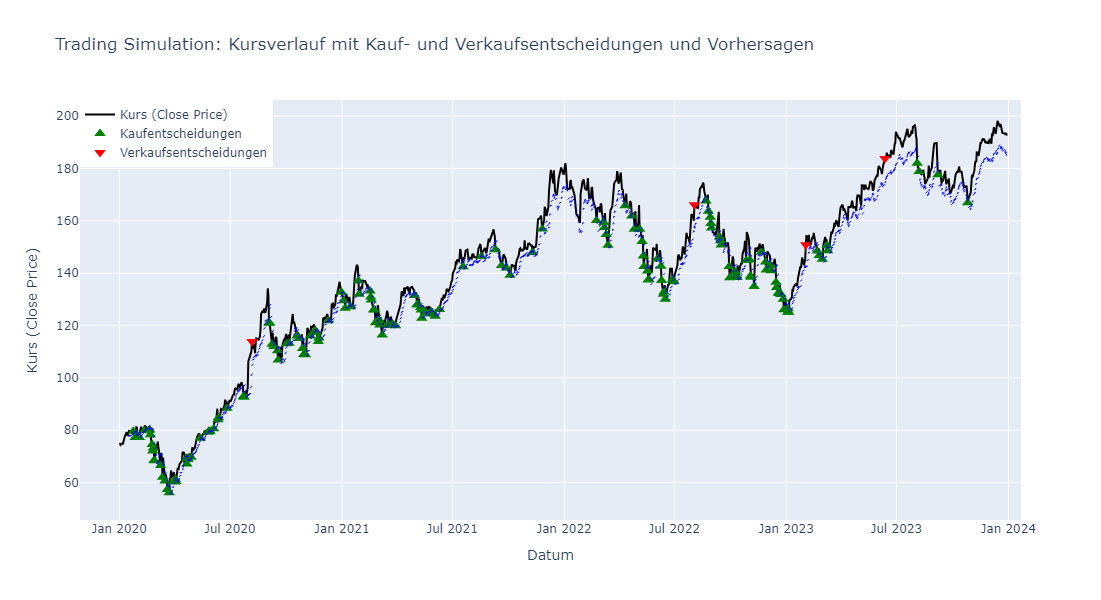

In [15]:
import numpy as np
import plotly.graph_objs as go
import yfinance as yf
import joblib
import pandas as pd

# Laden des trainierten Modells
#model_path = './models/model_20241013-123142_ws20_fs4_bs1_epochs30_units32_layers3.keras'
#model = load_model(model_path)

# Laden der Daten für die Simulation
symbol = "AAPL"
#start_date = "2024-01-02"  # Daten nach dem Ende des Trainingsdatensatzes
#end_date = "2024-10-14"

start_date = "2020-01-01"
end_date = "2024-01-01"

df_sim = yf.download(symbol, start=start_date, end=end_date)

# Features und Target wie beim Training vorbereiten
features_sim = df_sim[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
target_sim = df_sim['Close']

# Skalierung der Daten (verwende die gleichen Skalierer wie im Training)
scaled_features_sim = np.zeros_like(features_sim)

for i, column in enumerate(features_sim.columns):
    scaler = joblib.load(f'./scaler/{column}_scaler.pkl')
    scaled_features_sim[:, i] = scaler.transform(features_sim[column].values.reshape(-1, 1)).flatten()

target_scaler = joblib.load('./scaler/target_scaler.pkl')
scaled_target_sim = target_scaler.transform(target_sim.values.reshape(-1, 1))

# Sliding-Window für die Simulation erstellen
def create_sliding_window(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)

window_size = 10
future_steps = 4


X_sim = create_sliding_window(scaled_features_sim, window_size)

# Simulation starten
initial_capital = 10000  # Startkapital in USD
cash = initial_capital
shares = 0
buy_price = 0  # Speichert den Preis, zu dem die Aktien gekauft wurden
trade_amount = 20  # Fester Wert pro Trade
trade_fee = 1  # Gebühr pro Kauf oder Verkauf
min_profit_threshold = 1.2  # Mindestgewinn von 2%
trading_log = []

# Listen zur Speicherung von Kaufentscheidungen
buy_signals = []
sell_signals = []
prediction_lines = []

for i in range(len(X_sim)):
    # Vorhersagen mit dem Modell machen
    X_input = X_sim[i].reshape(1, X_sim.shape[1], X_sim.shape[2])
    y_pred_scaled = model.predict(X_input)
    y_pred_rescaled = target_scaler.inverse_transform(y_pred_scaled).flatten()

    current_price = target_sim.values[window_size + i]  # Aktueller Preis
    
    # Berechnung des Trends: Durchschnitt der 4 vorhergesagten Werte
    predicted_average = np.mean(y_pred_rescaled)  # Durchschnitt aller 4 Vorhersagewerte
    trend = predicted_average - current_price  # Differenz zwischen dem Durchschnitt der Vorhersagen und dem aktuellen Preis

    # Visualisierung der Vorhersagen für die nächsten 4 Tage
    future_dates = df_sim.index[window_size + i:window_size + i + future_steps]
    prediction_lines.append((future_dates, y_pred_rescaled))  # Speichern der Vorhersagedaten und -werte
    
    if trend > 0:
        # Aufwärtstrend erkannt, kaufen
        if cash > (trade_amount + trade_fee):  # Nur kaufen, wenn genug Bargeld vorhanden
            shares_to_buy = trade_amount / current_price  # Berechnung der Anzahl von Aktien
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price + trade_fee
                cash -= cost
                shares += shares_to_buy
                buy_price = current_price  # Kaufpreis speichern
                buy_signals.append((df_sim.index[window_size + i], current_price))  # Kauf speichern
                trading_log.append(f"Tag {window_size + i}: Gekauft {shares_to_buy} Aktien zu {current_price}, Kosten: {cost}, Barbestand: {cash}")
    
    elif trend < 0 and shares > 0:
        # Überprüfen, ob der Verkauf genügend Gewinn nach Gebühren erzielt
        potential_sale_value = shares * current_price - trade_fee
        cost_basis = shares * buy_price + trade_fee  # Kaufpreis und Gebühren
        
        # Prüfen, ob der Verkauf einen Gewinn von mind. 2% nach Abzug der Gebühren erzielt
        if potential_sale_value > cost_basis * min_profit_threshold:
            sale_value = potential_sale_value
            cash += sale_value
            sell_signals.append((df_sim.index[window_size + i], current_price))  # Verkauf speichern
            trading_log.append(f"Tag {window_size + i}: Verkauft {shares} Aktien zu {current_price}, Erlös: {sale_value}, Barbestand: {cash}")
            shares = 0

# Wert am Ende der Simulation berechnen
final_value = cash + shares * target_sim.values[-1]  # Der Wert des Barbestands und der restlichen Aktien
profit = final_value - initial_capital

# Ergebnisse ausgeben
print("Trading Simulation beendet.")
print(f"Startkapital: ${initial_capital}")
print(f"Endkapital: ${final_value}")
print(f"Gewinn/Verlust: ${profit}")

for log in trading_log:
    print(log)

# --- Plot mit Plotly erstellen ---
# Daten für das Plotten vorbereiten
buy_dates, buy_prices = zip(*buy_signals) if buy_signals else ([], [])
sell_dates, sell_prices = zip(*sell_signals) if sell_signals else ([], [])

# Erstellen des Plotly-Plots
fig = go.Figure()

# Kurslinie (Close Price)
fig.add_trace(go.Scatter(
    x=df_sim.index,
    y=target_sim,
    mode='lines',
    name='Kurs (Close Price)',
    line=dict(color='black', width=2)
))

# Kaufentscheidungen als grüne Punkte
fig.add_trace(go.Scatter(
    x=buy_dates,
    y=buy_prices,
    mode='markers',
    name='Kaufentscheidungen',
    marker=dict(color='green', size=10, symbol='triangle-up')
))

# Verkaufsentscheidungen als rote Punkte
fig.add_trace(go.Scatter(
    x=sell_dates,
    y=sell_prices,
    mode='markers',
    name='Verkaufsentscheidungen',
    marker=dict(color='red', size=10, symbol='triangle-down')
))

# Vorhersage-Linien für jeden Tag hinzufügen
for future_dates, future_predictions in prediction_lines:
    fig.add_trace(go.Scatter(
        x=future_dates,
        y=future_predictions,
        mode='lines',
        line=dict(color='blue', width=1, dash='dot'),
        showlegend=False,
    ))

# Layout des Plots anpassen
fig.update_layout(
    title='Trading Simulation: Kursverlauf mit Kauf- und Verkaufsentscheidungen und Vorhersagen',
    xaxis_title='Datum',
    yaxis_title='Kurs (Close Price)',
    legend=dict(x=0, y=1, traceorder='normal'),
    height=600
)

# Plot anzeigen
fig.show()
